In [32]:
import time
import os
from sagemaker import get_execution_role, session
import boto3
import sagemaker
from sagemaker import ModelPackage
from time import gmtime, strftime
from sagemaker.async_inference import AsyncInferenceConfig
import cv2
import urllib
import time
import json  
from botocore.exceptions import ClientError
import matplotlib.pyplot as plt
import numpy as np

region = boto3.Session().region_name
role = get_execution_role()
sm_client = boto3.client('sagemaker', region_name=region)

In [2]:
sagemaker_session=sagemaker.Session(default_bucket="sagemaker-us-east-1-470086202700")

In [3]:
model_package_arn="arn:aws:sagemaker:us-east-1:470086202700:model-package/balloon-segemntation-nonprod-group/2"

In [4]:
model = ModelPackage(role=role, 
                     model_package_arn=model_package_arn, 
                     sagemaker_session=sagemaker_session)

In [5]:
async_config = AsyncInferenceConfig(
    output_path='s3://sagemaker-us-east-1-470086202700/async_output/',
    max_concurrent_invocations_per_instance=1
)

In [6]:
 endpoint_name = 'ballon-segmentation-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

In [7]:
predictor = model.deploy(
    initial_instance_count=1,
    instance_type='ml.p3.2xlarge',
    endpoint_name=endpoint_name,
    async_inference_config=async_config
)

----------------------!

In [8]:
waiter = sm_client.get_waiter("endpoint_in_service")
print("Waiting for endpoint to create...")
waiter.wait(EndpointName=endpoint_name)
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)

print(f"Endpoint Status: {resp['EndpointStatus']}"),resp

Waiting for endpoint to create...
Endpoint Status: InService


(None,
 {'EndpointName': 'ballon-segmentation-2024-09-03-23-59-55',
  'EndpointArn': 'arn:aws:sagemaker:us-east-1:470086202700:endpoint/ballon-segmentation-2024-09-03-23-59-55',
  'EndpointConfigName': 'ballon-segmentation-2024-09-03-23-59-55',
  'ProductionVariants': [{'VariantName': 'AllTraffic',
    'DeployedImages': [{'SpecifiedImage': '470086202700.dkr.ecr.us-east-1.amazonaws.com/detectron2_segmentation@sha256:946fdc69fca58fae4961aecc04a44476d094bae482ac9126dc8bb6d03c5da205',
      'ResolvedImage': '470086202700.dkr.ecr.us-east-1.amazonaws.com/detectron2_segmentation@sha256:946fdc69fca58fae4961aecc04a44476d094bae482ac9126dc8bb6d03c5da205',
      'ResolutionTime': datetime.datetime(2024, 9, 3, 23, 59, 59, 116000, tzinfo=tzlocal())}],
    'CurrentWeight': 1.0,
    'DesiredWeight': 1.0,
    'CurrentInstanceCount': 1,
    'DesiredInstanceCount': 1}],
  'EndpointStatus': 'InService',
  'CreationTime': datetime.datetime(2024, 9, 3, 23, 59, 58, 318000, tzinfo=tzlocal()),
  'LastModifiedT

In [9]:
## Autoscaling the endpoint

In [11]:
client = boto3.client(
    "application-autoscaling"
)  # Common class representing Application Auto Scaling for SageMaker amongst other services

resource_id = (
    "endpoint/" + endpoint_name + "/variant/" + "AllTraffic"
)  # This is the format in which application autoscaling references the endpoint

# Configure Autoscaling on asynchronous endpoint down to zero instances
response = client.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    MinCapacity=0,
    MaxCapacity=1,
)

response = client.put_scaling_policy(
    PolicyName="Invocations-ScalingPolicy",
    ServiceNamespace="sagemaker",  # The namespace of the AWS service that provides the resource.
    ResourceId=resource_id,  # Endpoint name
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",  # SageMaker supports only Instance Count
    PolicyType="TargetTrackingScaling",  # 'StepScaling'|'TargetTrackingScaling'
    TargetTrackingScalingPolicyConfiguration={
        "TargetValue": 1.0,  # The target value for the metric. - here the metric is - SageMakerVariantInvocationsPerInstance
        "PredefinedMetricSpecification": {
            "PredefinedMetricType": "SageMakerVariantInvocationsPerInstance"
        },
        "ScaleInCooldown": 2,  # The cooldown period helps you prevent your Auto Scaling group from launching or terminating
        # additional instances before the effects of previous activities are visible.
        # You can configure the length of time based on your instance startup time or other application needs.
        # ScaleInCooldown - The amount of time, in seconds, after a scale in activity completes before another scale in activity can start.
        "ScaleOutCooldown": 2,  # ScaleOutCooldown - The amount of time, in seconds, after a scale out activity completes before another scale out activity can start.
        # 'DisableScaleIn': True|False - ndicates whether scale in by the target tracking policy is disabled.
        # If the value is true , scale in is disabled and the target tracking policy won't remove capacity from the scalable resource.
        "DisableScaleIn": False 
    },
)

In [16]:
image_path="test_balloon.jpg"
img=cv2.imread(image_path)

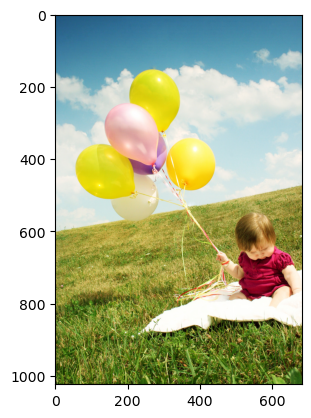

In [17]:
plt.imshow(img[...,::-1])

In [18]:
data = {
    "images": img.tolist(),
    "batch_size": 1
}
json_body = json.dumps(data)

In [19]:
byte_size = len(json_body.encode('utf-8'))
size_in_mb = byte_size / (1024 ** 2)
size_in_mb

10.728917121887207

In [20]:
s3 =  boto3.Session().client('s3')

In [21]:
bucket_name = 'sagemaker-us-east-1-470086202700'
file_path = 'async_inference/segm_input_data.json'
# Upload the serialized JSON to S3
s3.put_object(Bucket=bucket_name, Key=file_path, Body=json_body)

{'ResponseMetadata': {'RequestId': 'V5HVPVT59CT97HAB',
  'HostId': '92w6bs4XEy6CizTAKgpfKQTaFSAL+3+enl1MGLvRd1lGkABm9p6vetbXinLlVKkazNZRZc71FoBLOJ2adBQkAIxXnloc50lHtCGCM5wE6lI=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '92w6bs4XEy6CizTAKgpfKQTaFSAL+3+enl1MGLvRd1lGkABm9p6vetbXinLlVKkazNZRZc71FoBLOJ2adBQkAIxXnloc50lHtCGCM5wE6lI=',
   'x-amz-request-id': 'V5HVPVT59CT97HAB',
   'date': 'Wed, 04 Sep 2024 00:18:02 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"8bfba526a90ac72b1bca157cb486a69a"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"8bfba526a90ac72b1bca157cb486a69a"',
 'ServerSideEncryption': 'AES256'}

In [22]:
sm_runtime = boto3.Session().client('sagemaker-runtime')

In [23]:
input_location = f's3://{bucket_name}/{file_path}'

In [38]:
response = sm_runtime.invoke_endpoint_async(
    EndpointName=endpoint_name,
    InputLocation=input_location
)

In [39]:
output_location = response['OutputLocation']
output_location

's3://sagemaker-us-east-1-470086202700/async_output/22a8c672-2a9c-4b1b-95fa-61656bba948b.out'

In [40]:
def get_output(output_location):
    output_url = urllib.parse.urlparse(output_location)
    bucket = output_url.netloc
    key = output_url.path[1:]
    while True:
        try:
            file_content = sagemaker_session.read_s3_file(bucket=bucket, key_prefix=key)
            data = json.loads(file_content)
            return data  
        except ClientError as e:
            if e.response["Error"]["Code"] == "NoSuchKey":
                print("waiting for output...")
                time.sleep(2)
                continue
            raise

In [41]:
def rle_decode(rle, shape):
    rle = np.array(rle).reshape(-1, 2)
    run_lengths = rle[:, 0]
    run_values = rle[:, 1]
    pixels = np.repeat(run_values, run_lengths)
    return pixels.reshape(shape)

In [33]:
def visualize_masks_and_boxes(image, masks, boxes, color=(255, 0, 0), alpha=0.5):
    overlay = image.copy()
    output = image.copy()

    for i in range(masks.shape[0]):
        mask = masks[i, :, :]
        box = boxes[i, :]
        overlay[mask > 0] = color
        x1, y1, x2, y2 = box
        # Draw rectangle (bounding box)
        cv2.rectangle(output, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,0), 4)
    
    cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)
    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(output)
    plt.axis('off')
    plt.show()

In [34]:
results=get_output(output_location)

In [35]:
results.keys()

dict_keys(['masks', 'boxes', 'classes', 'scores', 'mask_shape'])

In [36]:
rle_masks=results["masks"]
masks_shape= results["mask_shape"]
masks=np.array([rle_decode(rle,masks_shape) for rle in rle_masks ])
boxes=np.array(results["boxes"])

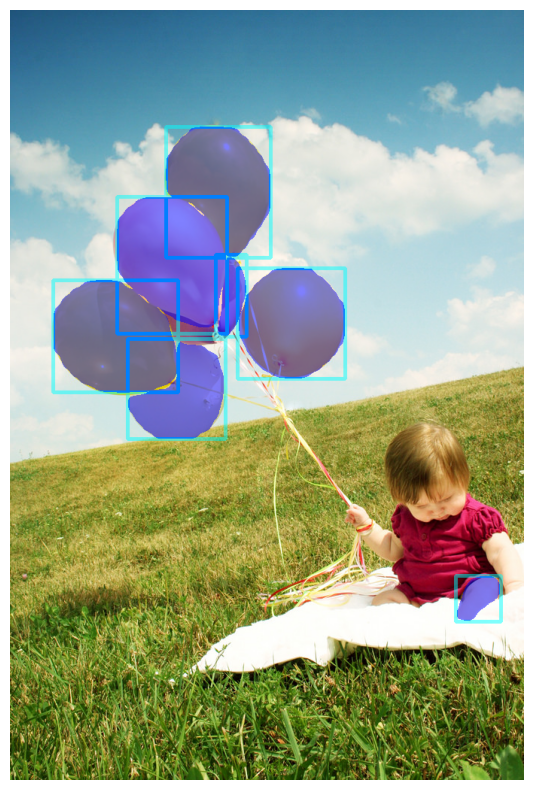

In [37]:
visualize_masks_and_boxes(img,masks,boxes)

In [ ]:
## Deregister the autoscaling

In [42]:
response = client.deregister_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
)

In [43]:
## Delete the endpoint

In [44]:
sm_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'aaa7a7e9-6a85-496e-b1db-ee09c03335b0',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'aaa7a7e9-6a85-496e-b1db-ee09c03335b0',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 04 Sep 2024 00:19:30 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}